In [30]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from imblearn.over_sampling import RandomOverSampler
import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim_models  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [31]:
df= pd.read_csv("bbc-text.csv")

In [32]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [33]:
df["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [34]:
df.shape

(2225, 2)

In [35]:
df["text"][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [36]:
stop_words = stopwords.words("english")
len(stop_words)

179

In [37]:
file = open(r"C:\Users\prakash kotian\Desktop\Data_Science\Deep Learning\NLP\NLP Basic\Topic Modelling\TOPIC MOdeling_Projects\stopwords\extended_stopwords.txt","r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

In [38]:
len(stop_words)

1527

In [39]:
file =open(r"C:\Users\prakash kotian\Desktop\Data_Science\Deep Learning\NLP\NLP Basic\Topic Modelling\TOPIC MOdeling_Projects\stopwords\contractions.txt","r")
contractions = ast.literal_eval(file.read())
file.close()

In [40]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [41]:
# Convert to list 
data = df.text.values.tolist()
print(len(data))

2225


In [42]:
data[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [43]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

print(data[0])

tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices. one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow people to record store play pause and forward wind tv programmes when they want. essentially the technology allows for much more personalised tv. they are also being built-in to high-definition tv sets

In [44]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode("utf-8"),deacc=True)) # deacc = true removes punctuations

data_words = list(sent_to_words(data))
print(data_words[0])

['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has

In [45]:
# Building  the bigram and trigram models
bigram =gensim.models.Phrases(data_words,min_count=5,threshold=100)# higher threshold fewer phraser.
trigram = gensim.models.Phrases(bigram[data_words],threshold=100)

In [46]:
# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [47]:
# See bigram example
print(bigram_mod[data_words[0]])

['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition', 'tvs', 'and', 'digital', 'video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics', 'show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital',

In [48]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [49]:
%%time 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Wall time: 38.5 s


In [50]:
print(len(data_lemmatized))

2225


In [51]:
" ".join(data_lemmatized[2])

'tiger wary gamble leicester rush make bid decide switch code involve process stage tiger radio leicest moment lot unknowns medical situation big big gamble persistent knee problem operation knee week ago expect month leicest saracen believe head list club interested signing decide move man game union well believe play back initially step league union involve centre prefer progress position row league skill forwards jury divide club balance strike cost gamble option bring ready replacement'

In [52]:
# create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)

In [53]:
list(id2word)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [54]:
# Create Corpous 
texts = data_lemmatized

In [56]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [57]:
#view
print(corpus[0])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 7), (10, 2), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 2), (18, 1), (19, 4), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 4), (68, 3), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 3), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 2), (90, 2), (91, 1), (92, 1), (93, 1), (94, 5), (95, 1), (96, 2), (97, 1), (98, 1), (99, 2), (100, 7), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1), (110, 1),

In [59]:
id2word[2]

'advertising'

In [61]:
# Human readable format of corpous (term-ferquency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abide', 1),
  ('advert', 1),
  ('advertising', 2),
  ('announce', 1),
  ('annual', 1),
  ('big', 2),
  ('bill_gate', 1),
  ('book', 1),
  ('box', 1),
  ('brand', 7),
  ('broadband', 2),
  ('build', 2),
  ('business', 1),
  ('button', 1),
  ('cable', 2),
  ('call', 1),
  ('capability', 2),
  ('ce', 2),
  ('challenge', 1),
  ('channel', 4),
  ('chief', 1),
  ('choice', 2),
  ('comfortable', 1),
  ('commercial', 1),
  ('communication', 1),
  ('company', 3),
  ('concern', 1),
  ('connection', 1),
  ('consumer', 1),
  ('consumer_electronic', 1),
  ('content', 4),
  ('control', 1),
  ('crystal', 1),
  ('deliver', 1),
  ('device', 1),
  ('diaper', 1),
  ('digital', 2),
  ('directtv', 1),
  ('discuss', 1),
  ('display', 1),
  ('dvd', 1),
  ('dvr', 3),
  ('enhance', 1),
  ('entertainment', 1),
  ('essentially', 1),
  ('experience', 1),
  ('expert', 1),
  ('external', 1),
  ('familiar', 1),
  ('favourite', 1),
  ('find', 2),
  ('firm', 1),
  ('forget', 1),
  ('forward', 2),
  ('free', 1),
  

In [62]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, # 
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,  
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [63]:
# can take a long time to run 
model_list,coherence_values = tune_model(dictionary=id2word,corpus=corpus,texts= data_lemmatized,start=2,limit =8, step=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:22<00:00, 23.68s/it]


In [64]:
import matplotlib.pyplot as plt

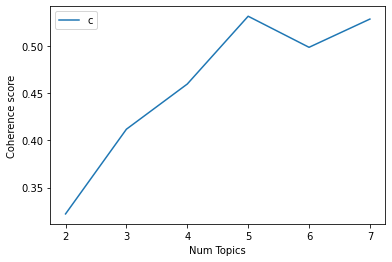

In [65]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.322
Num Topics = 3  has Coherence Value of 0.412
Num Topics = 4  has Coherence Value of 0.46
Num Topics = 5  has Coherence Value of 0.532
Num Topics = 6  has Coherence Value of 0.499
Num Topics = 7  has Coherence Value of 0.529


In [70]:
optical_model = model_list[3]
model_topics = optical_model.show_topics(formatted = False)
pprint(optical_model.print_topics(num_words=10))

[(0,
  '0.017*"people" + 0.010*"technology" + 0.008*"mobile" + 0.008*"computer" + '
  '0.008*"net" + 0.008*"network" + 0.007*"service" + 0.007*"user" + '
  '0.007*"site" + 0.007*"phone"'),
 (1,
  '0.023*"film" + 0.013*"year" + 0.011*"award" + 0.009*"music" + '
  '0.009*"include" + 0.008*"star" + 0.008*"top" + 0.007*"number" + '
  '0.006*"dance" + 0.006*"album"'),
 (2,
  '0.018*"year" + 0.013*"sale" + 0.013*"rise" + 0.012*"company" + 0.010*"firm" '
  '+ 0.008*"expect" + 0.007*"market" + 0.007*"fall" + 0.007*"price" + '
  '0.007*"share"'),
 (3,
  '0.010*"government" + 0.010*"people" + 0.008*"labour" + 0.007*"party" + '
  '0.007*"plan" + 0.005*"tell" + 0.005*"issue" + 0.005*"country" + '
  '0.005*"claim" + 0.005*"election"'),
 (4,
  '0.020*"game" + 0.015*"play" + 0.012*"player" + 0.011*"time" + 0.011*"win" + '
  '0.009*"year" + 0.007*"team" + 0.007*"club" + 0.007*"match" + 0.006*"good"')]


In [71]:
df["category"].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [73]:
x = optical_model.show_topics(num_topics=6, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
    print()
print()

print("---------------------")

0::['people', 'technology', 'mobile', 'computer', 'net', 'network', 'service', 'user', 'site', 'phone']

1::['film', 'year', 'award', 'music', 'include', 'star', 'top', 'number', 'dance', 'album']

2::['year', 'sale', 'rise', 'company', 'firm', 'expect', 'market', 'fall', 'price', 'share']

3::['government', 'people', 'labour', 'party', 'plan', 'tell', 'issue', 'country', 'claim', 'election']

4::['game', 'play', 'player', 'time', 'win', 'year', 'team', 'club', 'match', 'good']


---------------------


In [76]:
def format_topics_sentences(ldamodel=optical_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optical_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# add clean text Show
clean_text = [ " ".join(i) for i in texts]
final_df["Clean_Text"] = clean_text

# show
final_df.head(10)

,Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text
0,0.0,0.8349,"people, technology, mobile, computer, net, net...",tv future in the hands of viewers with home th...,tv future hand viewer theatre system plasma hi...
1,2.0,0.4834,"year, sale, rise, company, firm, expect, marke...",worldcom boss left books alone former worldcom...,boss leave book ebber accuse oversee fraud acc...
2,4.0,0.7149,"game, play, player, time, win, year, team, clu...",tigers wary of farrell gamble leicester say th...,tiger wary gamble leicester rush make bid deci...
3,4.0,0.9513,"game, play, player, time, win, year, team, clu...",yeading face newcastle in fa cup premiership s...,yeade face newcastle premiership side trip rym...
4,1.0,0.9510,"film, year, award, music, include, star, top, ...",ocean s twelve raids box office ocean s twelve...,raid box_office crime caper sequel star george...
5,3.0,0.8490,"government, people, labour, party, plan, tell,...",howard hits back at mongrel jibe michael howar...,hit mongrel jibe claim act attack mongrel labo...
6,3.0,0.8677,"government, people, labour, party, plan, tell,...",blair prepares to name poll date tony blair is...,prepare poll election day parliament return le...
7,4.0,0.7420,"game, play, player, time, win, year, team, clu...",henman hopes ended in dubai third seed tim hen...,hope end dubai seed slump straight set defeat ...
8,4.0,0.8565,"game, play, player, time, win, year, team, clu...",wilkinson fit to face edinburgh england captai...,return play injure bicep full contact training...
9,1.0,0.7213,"film, year, award, music, include, star, top, ...",last star wars not for children the sixth and ...,star_war child sixth final star_war movie suit...


In [78]:
final_df["Topic_No"].value_counts()

3.0    560
4.0    490
2.0    446
1.0    379
0.0    350
Name: Topic_No, dtype: int64

In [79]:
final_df.columns

Index(['Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text',
       'Clean_Text'],
      dtype='object')

# Classification 

In [80]:
from gensim.models import Word2Vec  
from sklearn.feature_extraction.text import TfidfVectorizer   
import pickle
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [81]:
# Vectorize training and testing data. Here we would pass TfidfVectorizer() to vec 
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    
    return X_train_vec, X_test_vec


In [82]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

In [83]:
## Preparing to make a pipeline 
models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
#     'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()   ## This model would take a little longer to run 
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
#     'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}


# Encode label categories to numbers
enc = LabelEncoder()
final_df['Topic_No'] = enc.fit_transform(final_df['Topic_No'])
labels = list(enc.classes_)

print(labels)

[0.0, 1.0, 2.0, 3.0, 4.0]


In [84]:
# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(final_df['Clean_Text'], final_df['Topic_No'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)
## ML_modeling method also prints performance scores for each classifier

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.973 	Precision: 0.973 	Recall: 0.975 		F1: 0.973



C:\Users\prakash kotian\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\prakash kotian\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\prakash kotian\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Detai

Decision Tree : {'min_samples_split': 5}
Accuracy: 0.755 	Precision: 0.752 	Recall: 0.755 		F1: 0.753



KeyboardInterrupt: 